In [126]:
# Part 1: Iris Classification

# Getting the Dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import torch

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


In [127]:
# Visualize the Data
df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


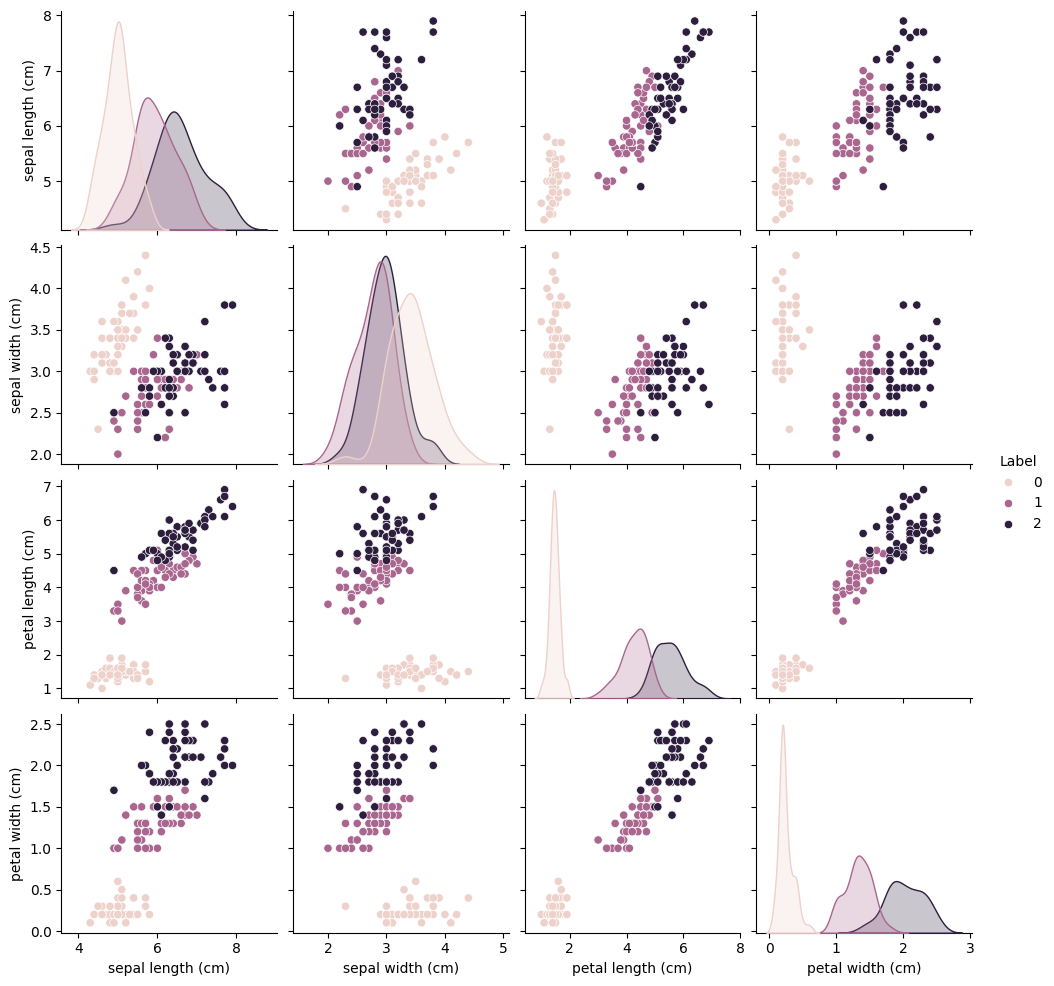

In [128]:
sns.pairplot(df,hue='Label')

In [129]:
# Code to normalize and encode the data
features_n = sklearn.preprocessing.normalize(features, return_norm=False)
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]


In [130]:
# Split the data
features_train, features_test, labels_train, labels_test = sklearn.model_selection.train_test_split(features_n,labels_onehot)

In [131]:
# Define the network

class MyNet(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self,hidden_size=30,func=torch.nn.ReLU()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size,dtype=float)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return torch.Tensor(x)  # Make sure x is a tensor

net = MyNet(func=torch.nn.ReLU())
print(net)


MyNet(
  (fc1): Linear(in_features=4, out_features=30, bias=True)
  (func): ReLU()
  (fc2): Linear(in_features=30, out_features=3, bias=True)
)


In [132]:
num_classes = 3

dataset = torch.utils.data.TensorDataset(torch.tensor(features_train),torch.tensor(labels_train,dtype=torch.float64))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

list(dataloader)[0]

[tensor([[0.7978, 0.5425, 0.2553, 0.0638],
         [0.8085, 0.5221, 0.2695, 0.0337],
         [0.8021, 0.5469, 0.2370, 0.0365],
         [0.7591, 0.3931, 0.4880, 0.1762],
         [0.6933, 0.3852, 0.5778, 0.1926],
         [0.7060, 0.2384, 0.6327, 0.2109],
         [0.7644, 0.2713, 0.5548, 0.1849],
         [0.7592, 0.3718, 0.5113, 0.1549],
         [0.7312, 0.3134, 0.5687, 0.2089],
         [0.7455, 0.3727, 0.5242, 0.1747],
         [0.8265, 0.4959, 0.2645, 0.0331],
         [0.8025, 0.5599, 0.2053, 0.0187],
         [0.6903, 0.3510, 0.5967, 0.2106],
         [0.8060, 0.5215, 0.2687, 0.0790],
         [0.7852, 0.5769, 0.2244, 0.0160],
         [0.7315, 0.2850, 0.5795, 0.2185]], dtype=torch.float64),
 tensor([[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0.,

In [133]:
# Train the network

def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.05):

    epoch_data = []
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        for (x, y) in dataloader:
            optim.zero_grad()
            z = net(x)
            loss = torch.nn.functional.cross_entropy(z, y) 
            loss.backward()
            optim.step()

        # Calculate validation accuracy
        with torch.no_grad():
            predictions = net(val_x)
           
            val_acc = calculate_accuracy(predictions, val_lab)
        
        epoch_data.append([loss,val_acc])
        print(f"Epoch {ep}: last batch loss = {loss}, val acc = {val_acc}")

    return epoch_data


In [134]:
def calculate_accuracy(predictions,val_lab):
    count = 0.0
    for i in range(predictions.size()[0]):
        predict = predictions[i].argmax()
        if (predict == val_lab[i].argmax()):
            count += 1
    return count/predictions.size()[0]

In [135]:
feat_tensor = torch.tensor(features_test)
lab_tensor = torch.tensor(labels_test)

loss_acc=train(net,dataloader,feat_tensor,lab_tensor,lr=0.05)


Epoch 0: last batch loss = 0.9859313300494208, val acc = 0.5789473684210527
Epoch 1: last batch loss = 0.661155859786441, val acc = 0.5789473684210527
Epoch 2: last batch loss = 0.4707899317534394, val acc = 0.5789473684210527
Epoch 3: last batch loss = 0.4637061845305954, val acc = 0.868421052631579
Epoch 4: last batch loss = 0.4860377921304347, val acc = 0.9736842105263158
Epoch 5: last batch loss = 0.4135816069965192, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.4363930363534304, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.45604034480802863, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.41916522677090623, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.40788677581816934, val acc = 0.9736842105263158


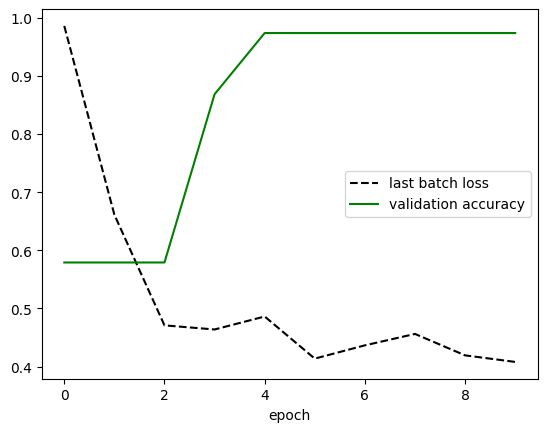

In [136]:
# Visualize train/validation accuracy graph

def plot_training_loss_acc(loss_acc):
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.legend(ax.lines, ['last batch loss', 'validation accuracy'], loc='upper center', ncol = 2)

    loss_list=[]
    acc_list=[]
    for epoch in loss_acc:
        try:
            loss_list.append(epoch[0].detach_())
        except AttributeError:
            loss_list.append(epoch[0])
        try:
            acc_list.append(epoch[1].detach_())
        except AttributeError:
            acc_list.append(epoch[1]) 

    ax.plot(range(len(loss_acc)), loss_list, 'k--', label='last batch loss')
    ax.plot(range(len(loss_acc)), acc_list, 'g-', label='validation accuracy')

    plt.legend()
    plt.show()
    
plot_training_loss_acc(loss_acc)

In [137]:
# Experiment

# TODO: One-layer network with 3 neurons (equal to the number of classes)
